# Сборный проект

## Задача
Изучить поведение пользователей мобильного приложения и результаты A/A/B-эксперимента. 


## Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Оглавление
- [Шаг 1. Предпросмотр данных](#step1)
- [Шаг 2. Подготовка данных](#step2)  
- [Шаг 3. Анализ данных](#step3) 
- [Шаг 4. Построение воронки событий](#step4) 
- [Шаг 5. Изучение A/A/B-эксперимента](#step5) 
- [Общий вывод](#step6)    

## Шаг 1. Предпросмотр данных<a id="step1"></a> 

Откроем и изучим данные

In [1]:
import pandas as pd
from datetime import datetime


import plotly.express as px
import numpy as np
from IPython.display import display
import math as mth
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="dark")
import scipy.stats as stats
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

log_data=pd.read_csv('/datasets/logs_exp.csv', sep='\t')
def info(data):
    display(data.head(10))
    display(data.info())
    for i in data.columns:
        display(data[i].value_counts())
info(log_data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

6304868067479728361    2308
197027893265565660     2003
4623191541214045580    1771
6932517045703054087    1448
1754140665440434215    1222
                       ... 
7724520246123323531       1
2760145394827990211       1
2086627244641656064       1
8164821368561674670       1
1083512226259476085       1
Name: DeviceIDHash, Length: 7551, dtype: int64

1564935799    9
1564670435    9
1565017227    8
1565191469    8
1564911846    8
             ..
1564717756    1
1564758720    1
1564766916    1
1564738250    1
1565191461    1
Name: EventTimestamp, Length: 176654, dtype: int64

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

Всего в логе 244 126 событий, поделенные на пять категорий, совершенные 7 551 пользователями, разделенными на 3 группы - 2 контрольные и 1 тестовую.

## Шаг 2. Подготовка данных <a id="step2"></a> 

Переименуем столбцы

In [2]:
log_data.columns=['event','user_id','timestamp','group']

В основном данным не надо менять тип, но столбик timestamp переведем в более понятный формат даты.

In [3]:
def to_date(row):
    wrong=row['timestamp']
    new=datetime.fromtimestamp(wrong).strftime('%Y-%m-%d %H:%M:%S')
    return new
log_data['date_time']=log_data.apply(to_date,axis=1)
log_data['date_time']=pd.to_datetime(log_data['date_time'], format='%Y.%m.%dT%H:%M:%S')
log_data['date']=log_data['date_time'].dt.date
display(log_data.info())
display(log_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
event        244126 non-null object
user_id      244126 non-null int64
timestamp    244126 non-null int64
group        244126 non-null int64
date_time    244126 non-null datetime64[ns]
date         244126 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


None

,event,user_id,timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Удалим дублирующиеся события

In [4]:
log_data=log_data.drop_duplicates()
log_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event        243713 non-null object
user_id      243713 non-null int64
timestamp    243713 non-null int64
group        243713 non-null int64
date_time    243713 non-null datetime64[ns]
date         243713 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


## Шаг 3. Анализ данных<a id="step3"></a> 

Изучим данные по-подробнее

In [5]:
print('В логе находится',log_data['event'].count(),'событий')

В логе находится 243713 событий


In [6]:
print('В логе находится',len(log_data['user_id'].unique()),'пользователей')

В логе находится 7551 пользователей


In [7]:
print('В среднем на одного человека приходится',round(log_data['event'].count()/len(log_data['user_id'].unique()),2),'события')

В среднем на одного человека приходится 32.28 события


Посмотрим повнимательнее на данные о количестве действий на сайте, совершаемых пользователями

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

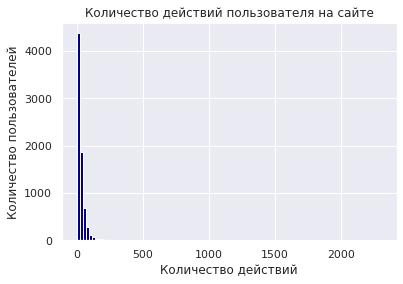

In [8]:
event_pivot=log_data.pivot_table(index='user_id',aggfunc={'event':'count'}).reset_index()
event_pivot['event'].hist(bins=100,color='darkblue')
plt.title('Количество действий пользователя на сайте')
plt.xlabel('Количество действий')
plt.ylabel('Количество пользователей')
event_pivot['event'].describe()

Есть выбивающиеся из общей массы пользователи, совершающие до 2307 событий. Отсечем таких, которые совершили более 150 событий, так как это скорее единичные случаи, которые в дальнейшем исказят нам тест. Всего лог сократится на 134 пользователей и 44436 событий.

count    7417.000000
mean       26.867601
std        24.710574
min         1.000000
25%         9.000000
50%        19.000000
75%        36.000000
max       149.000000
Name: event, dtype: float64

В логе находится 199277 событий
В логе находится 7417 пользователей


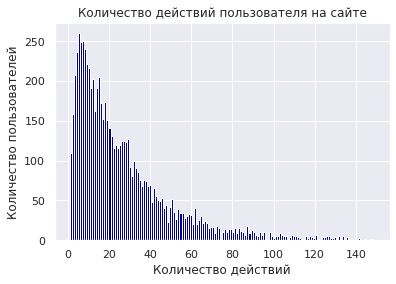

In [9]:
clean_event_pivot=event_pivot.query('event<150')
clean_event_pivot['event'].hist(bins=150,color='darkblue')
plt.title('Количество действий пользователя на сайте')
plt.xlabel('Количество действий')
plt.ylabel('Количество пользователей')
clean_event_id=clean_event_pivot['user_id']
clean_log_data=log_data.query('user_id in @clean_event_id')
display(clean_event_pivot['event'].describe())
print('В логе находится',clean_log_data['event'].count(),'событий')
print('В логе находится',len(clean_log_data['user_id'].unique()),'пользователей')

Минимальная дата - 25 июля.

Максимальная дата - 7 августа.

count                  199277
unique                 150932
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object

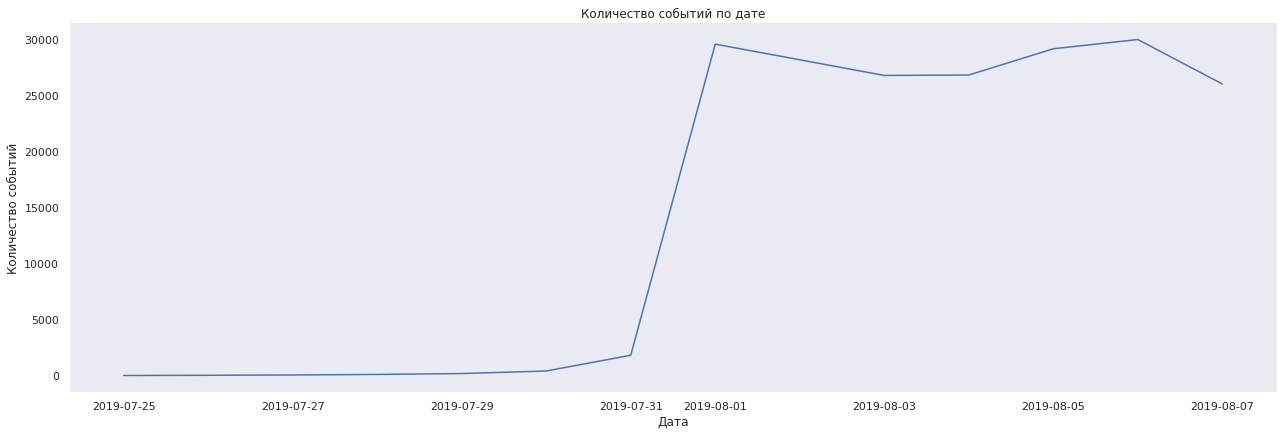

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
display(clean_log_data['date_time'].describe())

ax=sns.relplot(x='date',
            y='event', 
            kind="line",
            data=clean_log_data.pivot_table(index='date',aggfunc={'event':'count'}).reset_index(),
            height=6, aspect=3)
plt.title('Количество событий по дате')
plt.ylabel('Количество событий')
plt.xlabel('Дата');

По гистограмме видно, что полноценные данные начали поступать только с 1 августа, а до этого они были скорее единичными. Отсечем все июльские данные.

In [11]:
new_log_data=clean_log_data.query('date_time>"2019-07-31 23:59:59"')
new_log_data['date_time'].describe()

count                  196669
unique                 148502
top       2019-08-01 14:40:35
freq                        9
first     2019-08-01 00:07:28
last      2019-08-07 21:15:17
Name: date_time, dtype: object

In [12]:
print('В отброшенном логе находится',clean_log_data.query('date_time<="2019-07-31 23:59:59"')['event'].count(),'событий')
print('и',len(clean_log_data.query('date_time<="2019-07-31 23:59:59"')['user_id'].unique()),'пользователей')

В отброшенном логе находится 2608 событий
и 1407 пользователей


Посмотрим количество данных по группам.

In [13]:
new_log_data.groupby('group', as_index=False).agg({'user_id' : pd.Series.nunique})

,group,user_id
0,246,2439
1,247,2477
2,248,2484


В очищенном логе присутствуют данные по всем интересующим нас группам.

## Шаг 4. Построение воронки событий<a id="step4"></a> 

Изучим данные лога по событиям

,event,date_time
0,MainScreenAppear,110050
1,OffersScreenAppear,38250
2,CartScreenAppear,27023
3,PaymentScreenSuccessful,20379
4,Tutorial,967


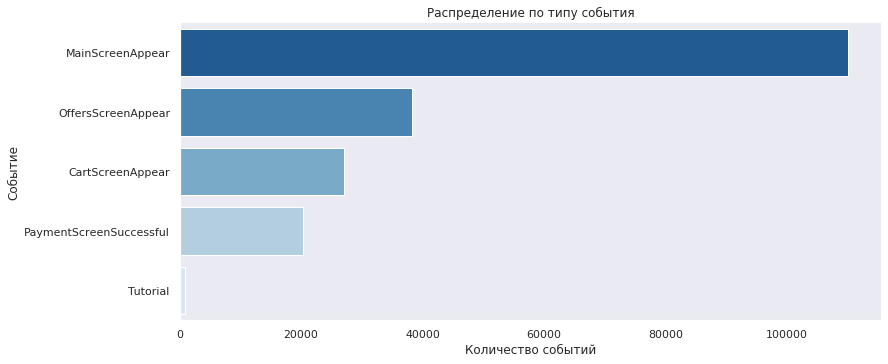

In [14]:
event_type_pivot=(new_log_data
                  .pivot_table(index='event'
                                          ,aggfunc={'date_time':'count'})
                  .sort_values(by='date_time',ascending=False)
                  .reset_index())
display(event_type_pivot)
def event_type(data,x_column):
    ax=sns.catplot(y="event"
            ,x=x_column
            ,kind="bar"
            , data=data
            , height=5
            , aspect=2.5
            , orient='h'
            ,palette="Blues_r"
           )
    plt.title('Распределение по типу события')
    plt.ylabel('Событие')
    plt.xlabel('Количество событий')
    plt.show()
event_type(event_type_pivot,'date_time')


Самое часто встречающееся событие - показ главного экрана. Меньше всего смотрят обучение. 

Изучим данные по количеству пользователей, совершивших события.

,event,user_id,user_share
0,MainScreenAppear,7287,98.47
1,OffersScreenAppear,4461,60.28
2,CartScreenAppear,3603,48.69
3,PaymentScreenSuccessful,3409,46.07
4,Tutorial,811,10.96


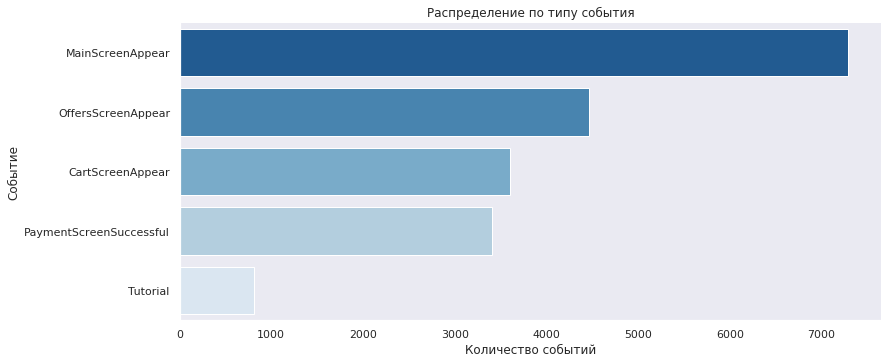

In [15]:
user_event_type_pivot=(new_log_data
                       .pivot_table(index=['event']
                                    ,aggfunc={'user_id':'nunique'})
                       .sort_values(by='user_id',ascending=False)
                       .reset_index())

user_event_type_pivot['user_share']=round(user_event_type_pivot['user_id']/len(new_log_data['user_id'].unique())*100,2)
display(user_event_type_pivot)
event_type(user_event_type_pivot,'user_id')

46% пользователей хоть раз совершили заказ за изучаемый период. Это очень хороший показатель. Однако, так же видно, что они шли к цели разными путями. Не все были на главной странице, не все шли через страницу предложения. А обучением занялось всего-лишь 11% пользователей, но эта конверсия нам меньше всего интересна в контексте данной задачи.

Изучим воронку, в которой пользователь посещает как главную страницу, так и страницу предложения.

,event,count,share,share_previous,lost
0,pageview,7287,100.00,100.00,0.00
1,offer,4090,56.13,56.13,-43.87
2,checkout,1716,23.55,41.96,-58.04
3,payment,1300,17.84,75.76,-24.24


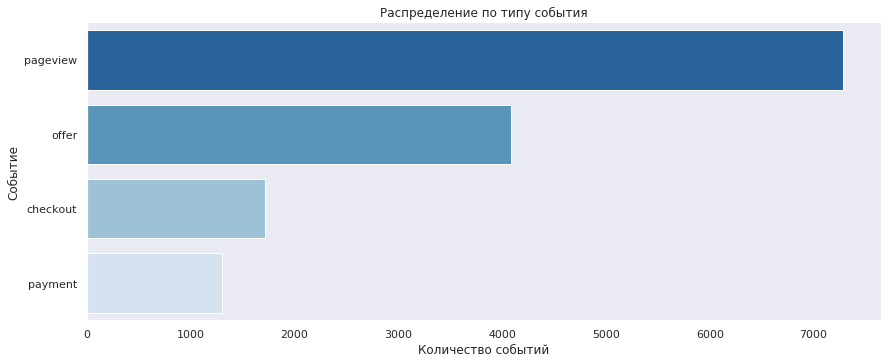

In [16]:
users = new_log_data.pivot_table(
    index='user_id', 
    columns='event', 
    values='date_time',
    aggfunc='min').reset_index()
step_1_f = ~users['MainScreenAppear'].isna()
step_2_f= step_1_f & (users['OffersScreenAppear'] >= users['MainScreenAppear']) 
step_3_f= step_2_f & (users['CartScreenAppear'] >= users['OffersScreenAppear']) 
step_4_f= step_3_f & (users['PaymentScreenSuccessful'] >= users['CartScreenAppear'])

n_pageviews_f = users[step_1_f].shape[0] 
n_offers_f = users[step_2_f].shape[0] 
n_checkout_f = users[step_3_f].shape[0] 
n_payment_f = users[step_4_f].shape[0] 

data_f = [{"event":"pageview","count": n_pageviews_f,'share':round(n_pageviews_f/n_pageviews_f*100,2),'share_previous':round(n_pageviews_f/n_pageviews_f*100,2)},
        {"event":"offer","count": n_offers_f,'share':round(n_offers_f/n_pageviews_f*100,2),'share_previous':round(n_offers_f/n_pageviews_f*100,2)},
        {"event":"checkout","count": n_checkout_f,'share':round(n_checkout_f/n_pageviews_f*100,2),'share_previous':round(n_checkout_f/n_offers_f*100,2)},
          {"event":"payment","count": n_payment_f,'share':round(n_payment_f/n_pageviews_f*100,2),'share_previous':round(n_payment_f/n_checkout_f*100,2)}]
funnel_f= pd.DataFrame(data_f)
funnel_f['lost'] = funnel_f['share_previous']-100
display(funnel_f)

event_type(funnel_f,'count')

В полной воронке всего 18% посетителей доходит от главной страницы до оплаты. При этом очень много людей теряется на этапе "Главная - Предложение", и еще больше - на этапе "Предложение-Корзина".

Предположим, что далеко не все пользователи проходят через страницу "Предложение", поэтому построим воронку, не учитывая её.

,event,count,share,share_previous,lost
0,pageview,7287,100.00,100.00,0.00
1,checkout,3317,45.52,45.52,-54.48
2,payment,2486,34.12,74.95,-25.05


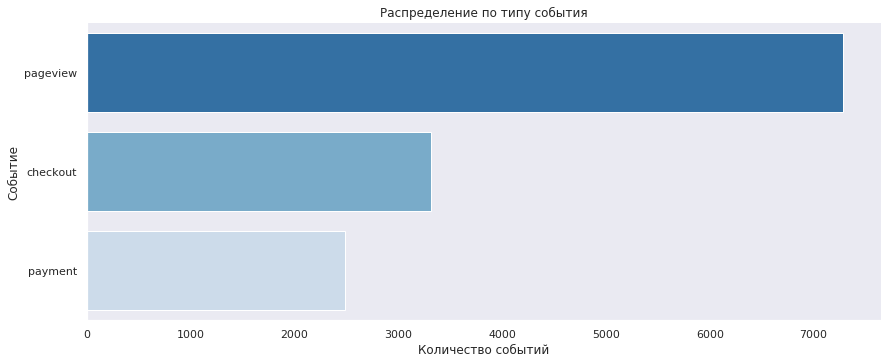

In [17]:
step_1_m =~users['MainScreenAppear'].isna()
step_2_m= step_1_m & (users['CartScreenAppear'] >= users['MainScreenAppear']) 
step_3_m= step_2_m & (users['PaymentScreenSuccessful'] >= users['CartScreenAppear'])

n_pageviews_m= users[step_1_m].shape[0]
n_checkout_m = users[step_2_m].shape[0] 
n_payment_m = users[step_3_m].shape[0]

data_m = [{"event":"pageview","count": n_pageviews_m,'share':round(n_pageviews_m/n_pageviews_m*100,2),'share_previous':round(n_pageviews_m/n_pageviews_m*100,2)},
        {"event":"checkout","count": n_checkout_m,'share':round(n_checkout_m/n_pageviews_m*100,2),'share_previous':round(n_checkout_m/n_pageviews_m*100,2)},
          {"event":"payment","count": n_payment_m,'share':round(n_payment_m/n_pageviews_m*100,2),'share_previous':round(n_payment_m/n_checkout_m*100,2)}]
funnel_m= pd.DataFrame(data_m)
funnel_m['lost'] = funnel_m['share_previous']-100
funnel_m
display(funnel_m)
event_type(funnel_m,'count')

Эта воронка учитывает больше количество пользователей, купивших товар, поэтому будем считать её основной. По ней можно заметить, что от главной до корзины доходит всего 45,5% пользователей, а при оплате теряется еще 25% пользователей. Однако оплачивают заказ 34% пользователей, посмотревших главную страницу, что является хорошей конверсией.

Изучим воронку пользователей, не посещающих главную страницу.

,event,count,share,share_previous,lost
0,offer,109,100.00,100.00,0.00
1,checkout,56,51.38,51.38,-48.62
2,payment,16,14.68,28.57,-71.43


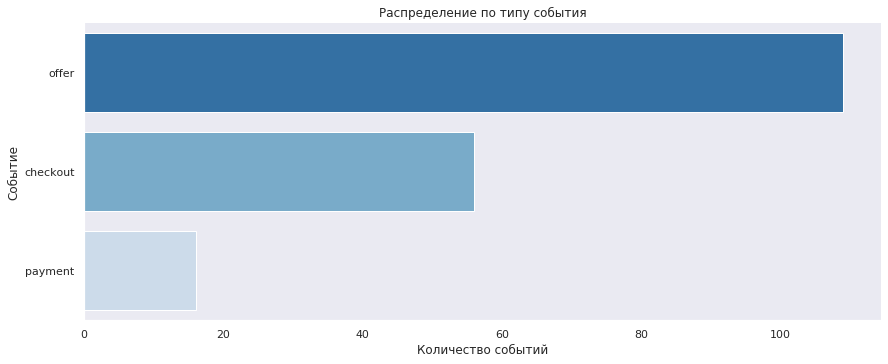

In [18]:
users_o=users[users['MainScreenAppear'].isna()].reset_index()
step_1_o =~users_o['OffersScreenAppear'].isna()
step_2_o= step_1_o & (users_o['CartScreenAppear'] >= users_o['OffersScreenAppear']) 
step_3_o= step_2_o & (users_o['PaymentScreenSuccessful'] >= users_o['CartScreenAppear'])
step_2_o
n_offers_o = users_o[step_1_o].shape[0]
n_checkout_o = users_o[step_2_o].shape[0] 
n_payment_o = users_o[step_3_o].shape[0]

data_o = [{"event":"offer","count": n_offers_o,'share':round(n_offers_o/n_offers_o*100,2),'share_previous':round(n_offers_o/n_offers_o*100,2)},
        {"event":"checkout","count": n_checkout_o,'share':round(n_checkout_o/n_offers_o*100,2),'share_previous':round(n_checkout_o/n_offers_o*100,2)},
          {"event":"payment","count": n_payment_o,'share':round(n_payment_o/n_offers_o*100,2),'share_previous':round(n_payment_o/n_checkout_o*100,2)}]
funnel_o= pd.DataFrame(data_o)
funnel_o['lost'] = funnel_o['share_previous']-100
display(funnel_o)
event_type(funnel_o,'count')

Как видно было выше, таких пользователей немного, и они менее охотно совершают покупки.

## Шаг 5. Изучение A/A/B-эксперимента<a id="step5"></a> 

Изучим данные о пользователей групп.

In [19]:
a1_group=new_log_data.query('group==246')
a2_group=new_log_data.query('group==247')
b_group=new_log_data.query('group==248')
user_a1_group=a1_group['user_id']
user_a2_group=a2_group['user_id']
user_b_group=b_group['user_id']
print('Количество пользователей в А1 группе -',user_a1_group.nunique())
print('Количество пользователей в А2 группе -',user_a2_group.nunique())
print('Количество пользователей в B группе -',user_b_group.nunique())

Количество пользователей в А1 группе - 2439
Количество пользователей в А2 группе - 2477
Количество пользователей в B группе - 2484


In [20]:
print('Количество пользователей группы а1 в группе а2-',a2_group.query('user_id in @user_a1_group')['user_id'].nunique())
print('Количество пользователей группы а2 в группе а1-',a1_group.query('user_id in @user_a2_group')['user_id'].nunique())
print('Количество пользователей группы b в группе а2-',a2_group.query('user_id in @user_b_group')['user_id'].nunique())
print('Количество пользователей группы b в группе а1-',a1_group.query('user_id in @user_b_group')['user_id'].nunique())
print('Количество пользователей группы а1 в группе b-',b_group.query('user_id in @user_a1_group')['user_id'].nunique())
print('Количество пользователей группы а2 в группе b-',b_group.query('user_id in @user_a2_group')['user_id'].nunique())

Количество пользователей группы а1 в группе а2- 0
Количество пользователей группы а2 в группе а1- 0
Количество пользователей группы b в группе а2- 0
Количество пользователей группы b в группе а1- 0
Количество пользователей группы а1 в группе b- 0
Количество пользователей группы а2 в группе b- 0


Количество пользователей в группах отличается более чем на 1%, но отличие достаточно невилико. Пользователей, которые попали в несколько групп нет.

Проведем проверку гипотезы о равенстве долей между контрольными группами.

In [21]:
def sravnenie_total (group1,group2,alpha):
    
    pre_pivot=new_log_data[(new_log_data['group']==group1) | (new_log_data['group']==group2) ].pivot_table(index='event'
                                                                                                  ,columns='group'
                                                                                                  ,values='user_id'
                                                                                                  ,aggfunc='count').sort_values(by=group1,ascending=False).reset_index()
    user_group1=new_log_data.loc[new_log_data['group']==group1,'user_id'].nunique()
    user_group2=new_log_data.loc[new_log_data['group']==group2,'user_id'].nunique()
    pivot=new_log_data[(new_log_data['group']==group1) | (new_log_data['group']==group2) ].pivot_table(index='event'
                                                                                                  ,columns='group'
                                                                                                  ,values='user_id'
                                                                                                  ,aggfunc='nunique').sort_values(by=group1,ascending=False).reset_index()
    
    pivot['share1']=round(pivot[group1]/user_group1*100,4)
    pivot['share2']=round(pivot[group2]/user_group2*100,4)
    print('Количество событий')
    display(pre_pivot)
    print()
    print('Количество пользователей')
    display(pivot)
    
    print('Проверка гипотез о равенстве долей')

    def check_hip(event, name):
        print()
        print(name)
        print('- H0= доли двух выборок равны')
        print('- H1= доли двух выборок отличаются')
        p1 = pivot.loc[pivot['event']==event,group1].values[0]/user_group1
        p2 = pivot.loc[pivot['event']==event,group2].values[0]/user_group2
        p_combined = (pivot.loc[pivot['event']==event,group1].values[0]+ pivot.loc[pivot['event']==event,group2].values[0]) / (
        user_group1+ user_group2)
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (
            1/user_group1 + 1/user_group2))
        distr = st.norm(0, 1)
        p_value =(1 - distr.cdf(abs(z_value))) * 2 
        print('p-значение: ', round(p_value,5))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    check_hip('MainScreenAppear', 'Доля пользователей, посетивших главный экран')    
    check_hip('OffersScreenAppear', 'Доля пользователей, посетивших страницу предложения')    
    check_hip('CartScreenAppear', 'Доля пользвателей, посетивших страницу корзины')  
    check_hip('PaymentScreenSuccessful', 'Доля пользвателей, посетивших страницу оплаты')
    check_hip('Tutorial', 'Доля пользвателей, посетивших страницу обучения')

sravnenie_total(246,247,0.05)

Количество событий


group,event,246,247
0,MainScreenAppear,35128,37226
1,OffersScreenAppear,12595,12953
2,CartScreenAppear,9333,8706
3,PaymentScreenSuccessful,7072,6573
4,Tutorial,301,327



Количество пользователей


group,event,246,247,share1,share2
0,MainScreenAppear,2406,2441,98.6470,98.5466
1,OffersScreenAppear,1498,1484,61.4186,59.9112
2,CartScreenAppear,1222,1202,50.1025,48.5264
3,PaymentScreenSuccessful,1156,1122,47.3965,45.2967
4,Tutorial,265,276,10.8651,11.1425


Проверка гипотез о равенстве долей

Доля пользователей, посетивших главный экран
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.76489
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользователей, посетивших страницу предложения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.27936
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу корзины
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.26911
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу оплаты
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.13991
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу обучения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p

Статистического различия между долями в контрольных группах нет.

Проведем проверку гипотезы о равенстве долей между первой контрольной и тестовой группами.

In [22]:
sravnenie_total(246,248,0.05)

Количество событий


group,event,246,248
0,MainScreenAppear,35128,37696
1,OffersScreenAppear,12595,12702
2,CartScreenAppear,9333,8984
3,PaymentScreenSuccessful,7072,6734
4,Tutorial,301,339



Количество пользователей


group,event,246,248,share1,share2
0,MainScreenAppear,2406,2440,98.6470,98.2287
1,OffersScreenAppear,1498,1479,61.4186,59.5411
2,CartScreenAppear,1222,1179,50.1025,47.4638
3,PaymentScreenSuccessful,1156,1131,47.3965,45.5314
4,Tutorial,265,270,10.8651,10.8696


Проверка гипотез о равенстве долей

Доля пользователей, посетивших главный экран
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.23693
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользователей, посетивших страницу предложения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.17792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу корзины
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.06404
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу оплаты
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.18957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу обучения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p

Статистического различия между долями в группах нет.

Проведем проверку гипотезы о равенстве долей между второй контрольной и тестовой группами.

In [23]:
sravnenie_total(247,248,0.05)

Количество событий


group,event,247,248
0,MainScreenAppear,37226,37696
1,OffersScreenAppear,12953,12702
2,CartScreenAppear,8706,8984
3,PaymentScreenSuccessful,6573,6734
4,Tutorial,327,339



Количество пользователей


group,event,247,248,share1,share2
0,MainScreenAppear,2441,2440,98.5466,98.2287
1,OffersScreenAppear,1484,1479,59.9112,59.5411
2,CartScreenAppear,1202,1179,48.5264,47.4638
3,PaymentScreenSuccessful,1122,1131,45.2967,45.5314
4,Tutorial,276,270,11.1425,10.8696


Проверка гипотез о равенстве долей

Доля пользователей, посетивших главный экран
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.374
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользователей, посетивших страницу предложения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.79042
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу корзины
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.4538
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу оплаты
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.86817
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу обучения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-зн

Статистического различия между долями в группах нет.

Проведем проверку гипотезы о равенстве долей между общей контрольной и тестовой группами.

In [25]:
new_log_data.loc[:,'group2']=new_log_data.loc[:,'group']
new_log_data.loc[(new_log_data['group']==246)|(new_log_data['group']==247),'group']='control'
sravnenie_total('control',248,0.05)

Количество событий


group,event,248,control
0,MainScreenAppear,37696,72354
1,OffersScreenAppear,12702,25548
2,CartScreenAppear,8984,18039
3,PaymentScreenSuccessful,6734,13645
4,Tutorial,339,628



Количество пользователей


group,event,248,control,share1,share2
0,MainScreenAppear,2440,4847,98.5964,98.2287
1,OffersScreenAppear,1479,2982,60.6591,59.5411
2,CartScreenAppear,1179,2424,49.3084,47.4638
3,PaymentScreenSuccessful,1131,2278,46.3385,45.5314
4,Tutorial,270,541,11.0049,10.8696


Проверка гипотез о равенстве долей

Доля пользователей, посетивших главный экран
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.22312
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользователей, посетивших страницу предложения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.35332
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу корзины
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.13383
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу оплаты
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-значение:  0.5107
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Доля пользвателей, посетивших страницу обучения
- H0= доли двух выборок равны
- H1= доли двух выборок отличаются
p-

Статистического различия между долями в группах нет.

На этом шаге было проверено 20 гипотез о равенстве долей при уровне значимости 0.05, все из которых не получилось отвергнуть. Если бы был использован уровень значимости 0.1, то из всех гипотез мы приняли бы альтернативную в сравнении первой контрольной группы с тестовой о разнице доли людей, переходящих в корзину. В остальных случаях решение не изменилось бы, нет смысла менять установленный уровень значимости.

## Шаг 5. Общий вывод <a id="step6"></a> 

Изучен лог работы приложения стартапа, который продает продукты питания. В изначальном логе содержалось 244 126 события, поделенные на пять категорий, совершенные 7 551 пользователями, разделенными на 3 группы - 2 контрольные и 1 тестовую. Лог был очищен от дублей,отклоняющихся значений и событий из другого периода.

Большинство пользователей мобильного приложения идет путем "Главный экран-Корзина-Оплата", не заглядывая на страницу Предложения и далеко не всегда пользуюясь обучением. 46% пользователей совершают покупку, при этом больше всего сокращается на этапе "Главный экран-Корзина".

При проведении A/A/B-теста было выявленно, что изменение шрифта никак не отразилось на поведении пользователей, поэтому приложение может продолжать работать дальше как со старыми, так и с новыми шрифтами.